Install Packages

In [ ]:
!pip install networkx matplotlib scikit-learn numpy scipy

Synthetic Graph Data

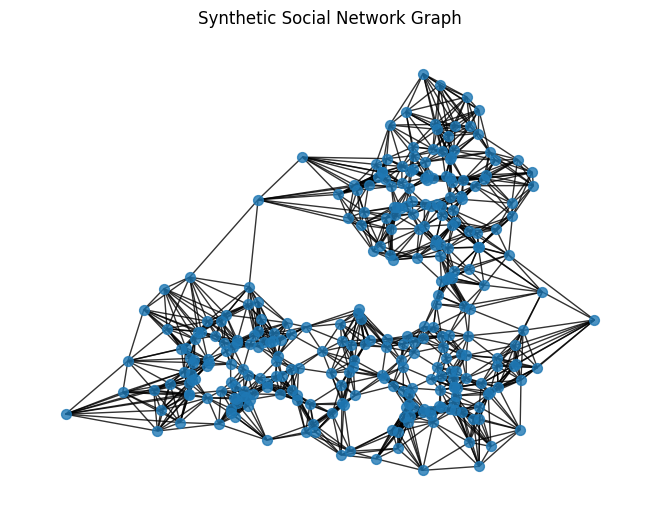

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate synthetic data (points in 2D space)
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=42)            # bro? I need to sleep.

# Create a graph from the data points
G = nx.Graph()

# Add nodes
for i in range(X.shape[0]):
    G.add_node(i, pos=X[i])

# Add edges based on distance (k-nearest neighbors)
for i in range(X.shape[0]):
    distances = np.sum((X - X[i])**2, axis=1)
    # Connect to 10 nearest neighbors (excluding self)
    nearest = np.argsort(distances)[1:11]
    for j in nearest:
        G.add_edge(i, j, weight=1.0/(1.0 + distances[j]))

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_size=50, alpha=0.8)
plt.title("Synthetic Social Network Graph")
plt.show()

Construct Graph Laplacian

In [ ]:
# Compute adjacency matrix
A = nx.adjacency_matrix(G).astype(float)

# Compute degree matrix
degrees = np.array([d for _, d in G.degree()])
D = np.diag(degrees)

# Compute unnormalized Laplacian
L = D - A

# Compute normalized Laplacian (symmetric version)
D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
L_norm = np.eye(len(G.nodes)) - D_inv_sqrt @ A @ D_inv_sqrt

print("Unnormalized Laplacian shape:", L.shape)
print("Normalized Laplacian shape:", L_norm.shape)

Unnormalized Laplacian shape: (300, 300)
Normalized Laplacian shape: (300, 300)


Compute Eigenvalues and Eigenvectors

First 3 eigenvalues: [0.06903913 0.07940378 0.08414228]


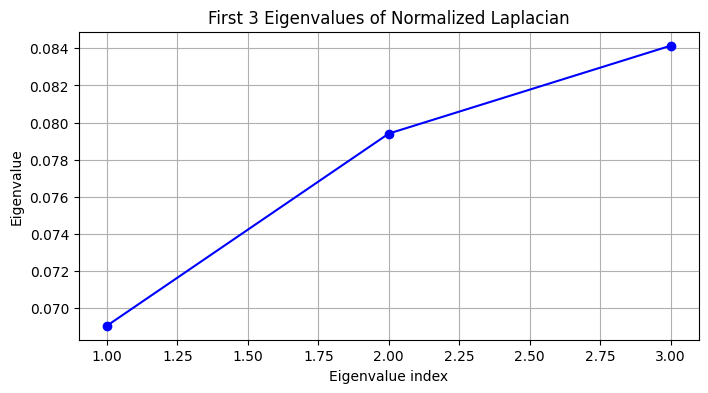

In [ ]:
from scipy.sparse.linalg import eigsh

# Compute first k eigenvalues and eigenvectors
k = 3  # we know we have 3 clusters
eigenvalues, eigenvectors = eigsh(L_norm, k=k, which='SM')

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

print("First", k, "eigenvalues:", eigenvalues)

# Plot the eigenvalues
plt.figure(figsize=(8, 4))
plt.plot(range(1, k+1), eigenvalues, 'bo-')
plt.title('First {} Eigenvalues of Normalized Laplacian'.format(k))
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

Specteral Clustering

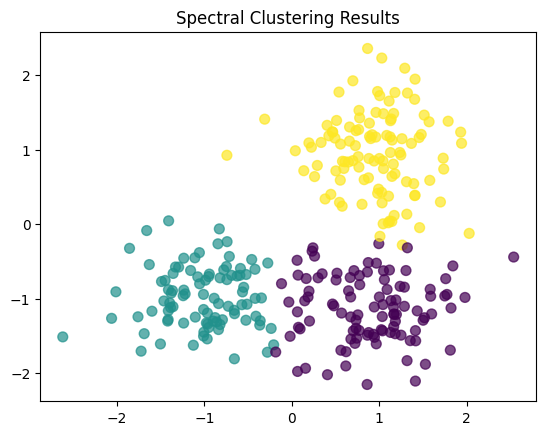

In [ ]:
# Use the eigenvectors as features for clustering
X_spectral = eigenvectors[:, 1:k]  # skip the first eigenvector (all ones)

# Normalize the rows to norm 1
X_spectral = X_spectral / np.linalg.norm(X_spectral, axis=1)[:, np.newaxis]

# Perform k-means on the eigenvector representation
kmeans_spectral = KMeans(n_clusters=k, random_state=42)
spectral_labels = kmeans_spectral.fit_predict(X_spectral)

# Visualize the clusters
plt.scatter(X[:, 0], X[:, 1], c=spectral_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("Spectral Clustering Results")
plt.show()

Comparison with Other Clustering Methods

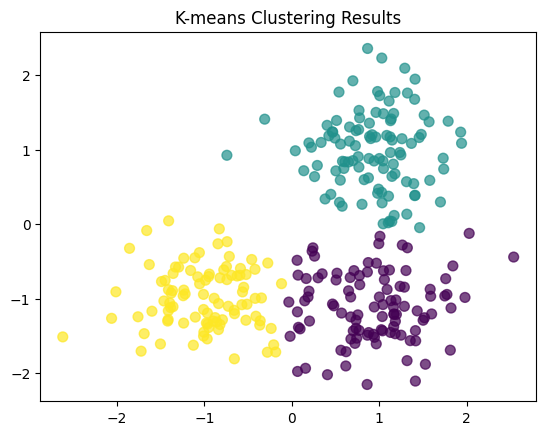

K-means ARI: 0.8935382279278485
Spectral Clustering ARI: 0.8478789160068264


In [ ]:
# Standard k-means on original data
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Visualize
plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("K-means Clustering Results")
plt.show()

# Compare with ground truth
print("K-means ARI:", adjusted_rand_score(labels_true, kmeans_labels))
print("Spectral Clustering ARI:", adjusted_rand_score(labels_true, spectral_labels))

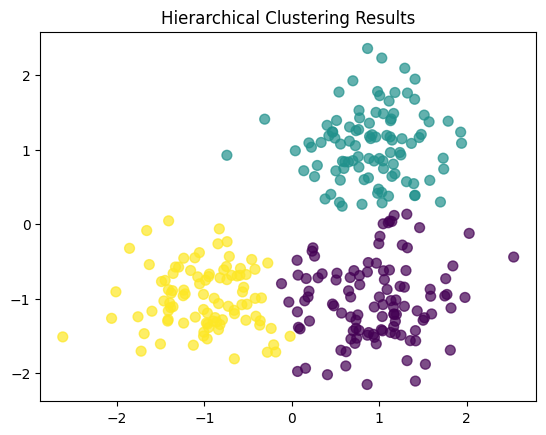

Hierarchical Clustering ARI: 0.8637837952375259


In [ ]:
# Hierarchical clustering
agg = AgglomerativeClustering(n_clusters=k)
agg_labels = agg.fit_predict(X)

# Visualize
plt.scatter(X[:, 0], X[:, 1], c=agg_labels, cmap='viridis', s=50, alpha=0.7)
plt.title("Hierarchical Clustering Results")
plt.show()

print("Hierarchical Clustering ARI:", adjusted_rand_score(labels_true, agg_labels))

Performance Comparison

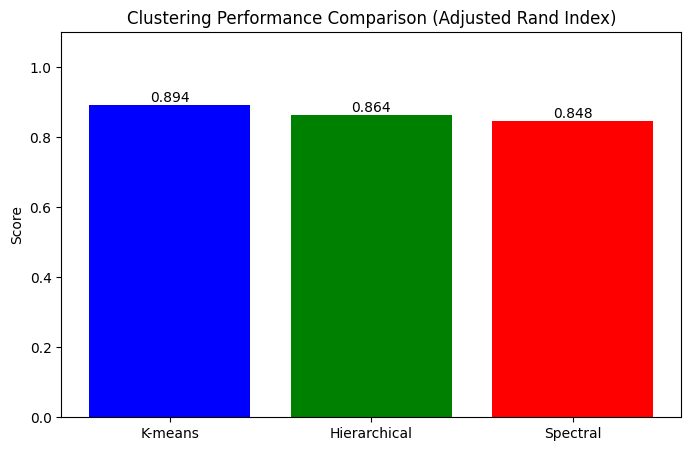

In [ ]:
# Compare all methods
methods = ['K-means', 'Hierarchical', 'Spectral']
scores = [adjusted_rand_score(labels_true, kmeans_labels),
          adjusted_rand_score(labels_true, agg_labels),
          adjusted_rand_score(labels_true, spectral_labels)]

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, scores, color=['blue', 'green', 'red'])
plt.title('Clustering Performance Comparison (Adjusted Rand Index)')
plt.ylabel('Score')
plt.ylim(0, 1.1)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.show()